In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

def plot_daterange(df):
    all_dates = get_datestr_range(start=df.datestr.min(), end=df.datestr.max())
    hist_dict = df.datestr.value_counts().to_dict()
    mydict = {}
    for d in all_dates:
        if d not in list(hist_dict.keys()):
            mydict[d] = 0
        else:
            mydict[d] = hist_dict[d]

    series = pd.Series(mydict)
    series.plot(rot=90, style='.-')
    return series

Available workers: 16


In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = 32
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw'
normalize = ""#"sample"

train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(), RandomRoll() ,RandomFlip()]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass()]


In [4]:
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

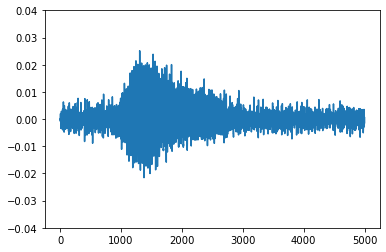

In [5]:
plot_wingbeat(train_dataset, idx=2)

In [6]:
outs = 2
if modeltype == 'wingbeatraw':
    model = DrosophilaNetRAW(outputs=outs, dropout_p=.2)
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=outs))

class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Testing on test set

In [8]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_best_time_signals.pth.tar', model, optimizer)

In [9]:
model = model.to('cuda', dtype=torch.float)

In [11]:
_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 803/803 [00:47<00:00, 17.04it/s]


Accuracy: 89.94
Balanced accuracy: 89.62
Confusion matrix: 
[[0.83887742 0.16112258]
 [0.04646018 0.95353982]]


In [10]:
df_out = get_all_preds(model, test_dataloader, dataframe=True)
df_out['wavnames'] = df_out['fnames'].apply(lambda x: x.split('/')[8][:-4])
df_out["date"] = df_out.wavnames.apply(lambda x: pd.to_datetime(''.join(x.split('_')[0:2]), 
                                                                        format='F%y%m%d%H%M%S'))

100%|██████████| 803/803 [00:07<00:00, 111.78it/s]


In [14]:
df_out['datestr'] = df_out['date'].apply(lambda x: x.strftime("%Y%m%d"))
df_out['date_day'] = df_out['date'].apply(lambda x: x.day)
df_out['date_hour'] = df_out['date'].apply(lambda x: x.hour)

df_suz = df_out[df_out.y == 1]
df_mel = df_out[df_out.y == 0]
miss_mel = df_mel[(df_mel.y==0) & (df_mel.softmax==1)]
miss_suz = df_suz[(df_suz.y==1) & (df_suz.softmax==0)]

In [15]:
sns.set(font_scale=1.4)

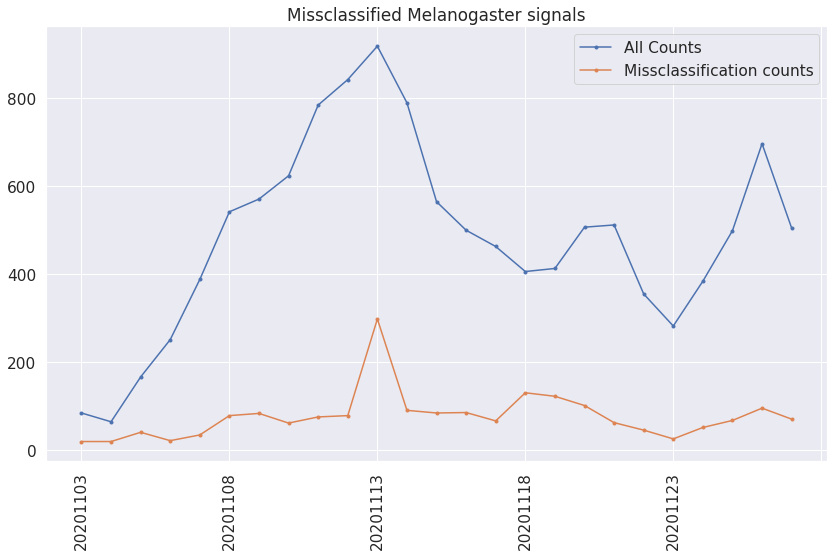

In [16]:
plt.figure(figsize=(14,8))
plot_daterange(df_mel)
plot_daterange(miss_mel)
plt.title("Missclassified Melanogaster signals")
plt.legend(['All Counts', "Missclassification counts"]);
plt.savefig("/home/kalfasyan/Desktop/missed_mel.png", bbox_inches="tight", pad_inches=0)

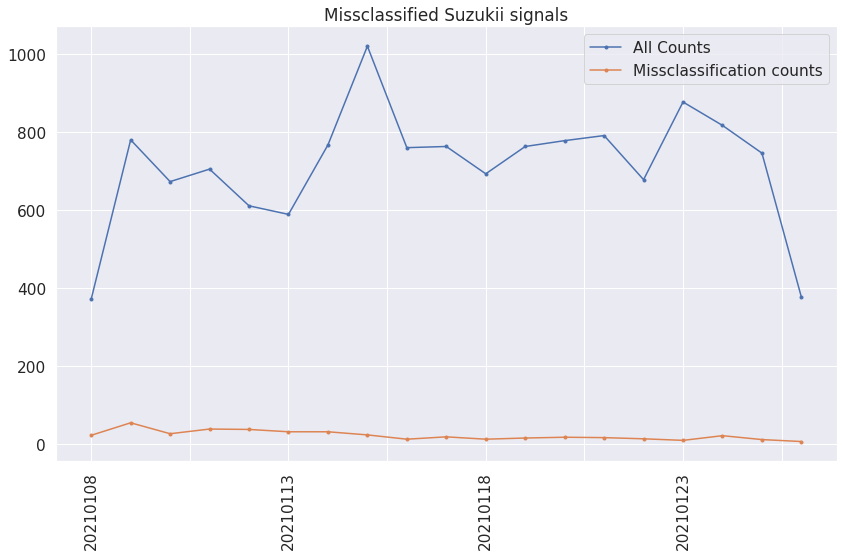

In [17]:
plt.figure(figsize=(14,8))
plot_daterange(df_suz)
plot_daterange(miss_suz)
plt.title("Missclassified Suzukii signals")
plt.legend(['All Counts', "Missclassification counts"]);
plt.savefig("/home/kalfasyan/Desktop/missed_suz.png", bbox_inches="tight", pad_inches=0)

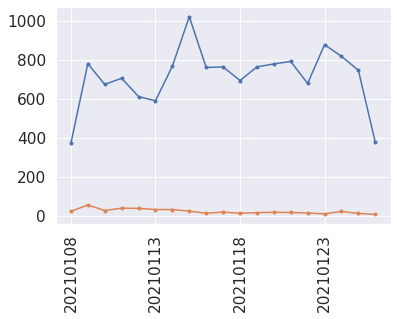

In [40]:
ser0 = plot_daterange(df_suz);
ser1 = plot_daterange(miss_suz);

In [41]:
ser0.std()

152.06177568912904

In [42]:
ser1.std()

12.101664860574385

## Testing on extra mebios data

In [15]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [17]:
len(extra_dataset)

24568

In [18]:
_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 768/768 [00:07<00:00, 109.04it/s]


Accuracy: 94.26
Balanced accuracy: 90.09
Confusion matrix: 
[[0.8540146  0.1459854 ]
 [0.05220278 0.94779722]]


In [140]:
df_out = get_all_preds(model, extra_dataloader, dataframe=True)
df_out['wavnames'] = df_out['fnames'].apply(lambda x: x.split('/')[8][:-4])
df_out["date"] = df_out.wavnames.apply(lambda x: pd.to_datetime(''.join(x.split('_')[0:2]), 
                                                                        format='F%y%m%d%H%M%S'))

100%|██████████| 768/768 [00:06<00:00, 115.38it/s]


In [141]:
df_out['datestr'] = df_out['date'].apply(lambda x: x.strftime("%Y%m%d"))
df_out['date_day'] = df_out['date'].apply(lambda x: x.day)
df_out['date_hour'] = df_out['date'].apply(lambda x: x.hour)

df_suz = df_out[df_out.y == 1]
df_mel = df_out[df_out.y == 0]
miss_mel = df_mel[(df_mel.y==0) & (df_mel.softmax==1)]
miss_suz = df_suz[(df_suz.y==1) & (df_suz.softmax==0)]

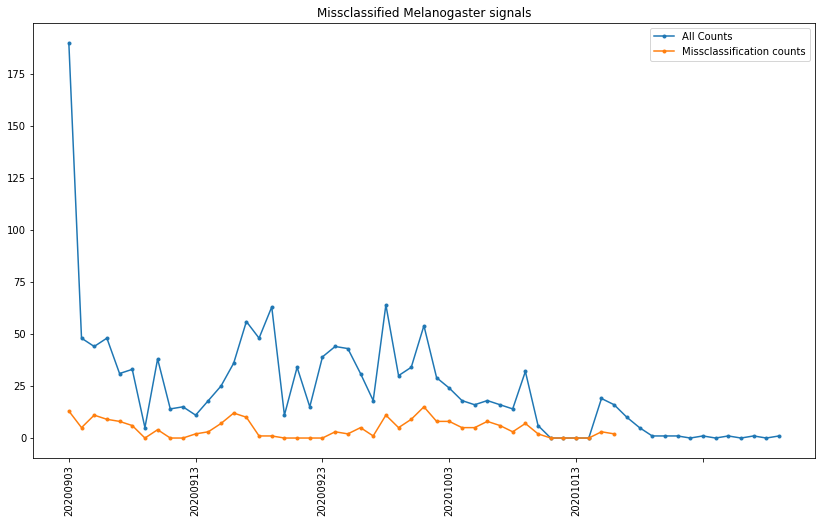

In [142]:
plt.figure(figsize=(14,8))
plot_daterange(df_mel)
plot_daterange(miss_mel)
plt.title("Missclassified Melanogaster signals")
plt.legend(['All Counts', "Missclassification counts"]);

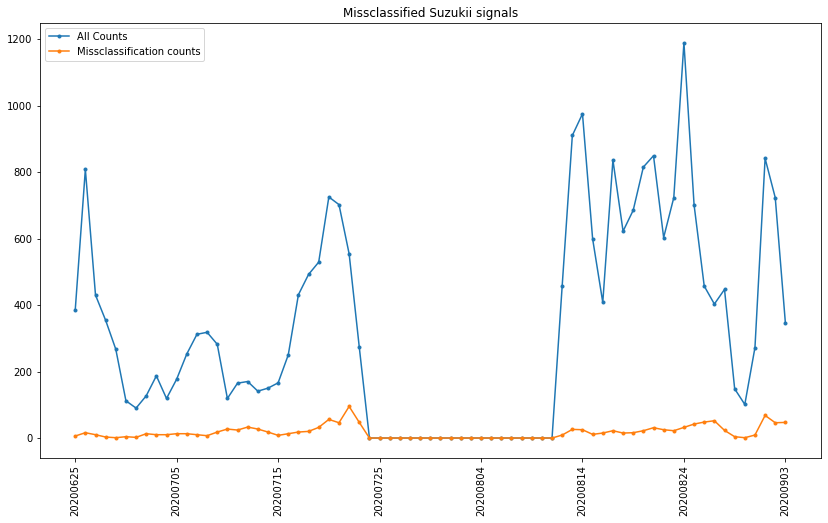

In [143]:
plt.figure(figsize=(14,8))
plot_daterange(df_suz)
plot_daterange(miss_suz)
plt.title("Missclassified Suzukii signals")
plt.legend(['All Counts', "Missclassification counts"]);

## EXTRA

In [12]:
def softmax_out(x):
    return np.argmax(F.softmax(x, dim=1), axis=1).tolist()[0]

In [13]:
from utils import get_all_preds
model = nn.Sequential(*list(model.children())[:-1])
model = model.to('cuda', dtype=torch.float)
model.eval()
# df_out = get_all_preds(model, test_dataloader, dataframe=True)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (1): ReLU()
  (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (5): ReLU()
  (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (9): ReLU()
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (13): ReLU()
  (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv1d(128, 256, kernel_size=

In [14]:
all_preds = torch.tensor([]).cuda()
with torch.no_grad():

    all_preds = torch.tensor([]).cuda()
    all_labels = torch.tensor([]).cuda()
    all_paths = []
    all_idx = torch.tensor([]).cuda()
    for x_batch, y_batch, path_batch, idx_batch in tqdm(test_dataloader):

        preds = model(x_batch.cuda())
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, y_batch.cuda()), dim=0)
        all_paths.extend(path_batch)
        all_idx = torch.cat((all_idx, idx_batch.cuda()), dim=0)
    
    out = all_preds,all_labels,all_paths,all_idx

100%|██████████| 803/803 [00:07<00:00, 103.45it/s]


In [15]:
y_scores = out[0].squeeze().cpu()

In [16]:
y_true = out[1].cpu()

In [18]:
y_scores

tensor([[ 0.2698,  0.1834, -0.3383,  ..., -0.0026, -0.1126,  0.4434],
        [-0.5059, -0.2086, -0.3918,  ..., -0.2205,  0.4613,  0.9703],
        [-0.1636,  0.2902, -0.3918,  ...,  0.4007, -0.2040,  0.6446],
        ...,
        [-0.0579,  0.1645,  0.0736,  ..., -0.1553,  0.2873,  0.5796],
        [-0.5316, -0.2894, -0.3918,  ..., -0.3845,  0.1779,  0.9869],
        [-0.4468,  0.0600, -0.3918,  ..., -0.0685, -0.1129,  0.8366]])

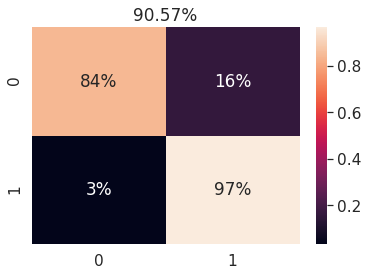

In [156]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')
sns.heatmap(cm, annot=True, fmt='.0%')
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");

In [ ]:
df_out.y.value_counts()#.value_counts()

In [ ]:
y_true = df_out.y.tolist()
y_pred=df_out.softmax.tolist()
y_scores = df_out[['pred0','pred1']].values

In [ ]:
import umap
import umap.plot

In [ ]:
plt.figure(figsize=(20,14));

mapper = umap.UMAP(random_state=42).fit(y_scores)
umap.plot.points(mapper, labels=np.array(y_true));

# ------------------------------------------